In [35]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking(iris64_label1)")
OBJ_FUNC = r'$\mathcal{L}_{\phi, \lambda}$'

In [36]:
plt.style.use('./styles/figstyle.mplstyle')
plt.style.reload_library()

In [37]:
from pandas import read_csv, DataFrame
data = read_csv(DATA_DIR/'sample_summary.csv')

training_data = np.load(DATA_DIR/'Dataset #0/training_data.npy')
test_data = np.load(DATA_DIR/'Dataset #0/test_data.npy')
training_label = np.load(DATA_DIR/'Dataset #0/training_label.npy')
test_label = np.load(DATA_DIR/'Dataset #0/test_label.npy')

In [38]:
import dill
import json

with open(DATA_DIR/"setting.json", 'r') as fp:
    _setting = json.load(fp)
_setting_save = _setting["Saving results"]
_setting_data = _setting["Data set selection"]
_setting_qasvm = _setting["SoftQASVM setting"]
_setting_simulator = _setting["Simulator setting"]
_setting_optimizer = _setting["Optimizer setting"]
_setting_rep = _setting["Repetition setting"]

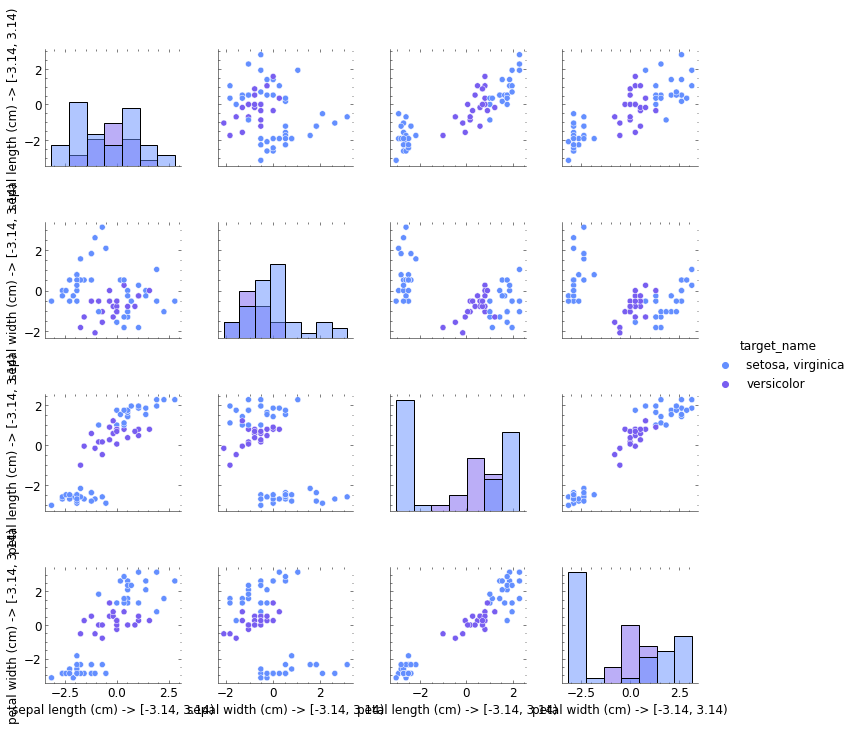

In [40]:
from classifiers.datasets import SklearnDataset

ds = SklearnDataset('iris', (-np.pi, np.pi), true_hot=1)
ds.plot(ds.sample_training_and_test_dataset((len(training_label), len(test_label)), return_X_y=False, random_state=_setting_rep["SEED"])[0])

In [41]:
C = _setting_qasvm["C"]
lamda = _setting_qasvm["LAMBDA"]

In [42]:
def fval(did, cid, layer, reps):
    with open(DATA_DIR/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

with open(DATA_DIR/f"Dataset #{0}/Circuit #{1}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm = dill.load(fp)

training_kernel = _qasvm.kernel_matrix
test_kernel = _qasvm._qk.evaluate(test_data, training_data)

In [43]:
from classifiers.convex.svm import CvxSoftQASVM

svm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm.fit(training_kernel, training_label)
true_f = svm.f(test_kernel)

In [44]:
true_f/svm.dual_objective_value

array([-1.54803262,  1.54735169, -1.68287366, -1.16128508, -1.19442615,
       -2.86757782, -1.69467096, -0.78152473, -1.02051097, -0.98322786,
       -0.42465992, -1.42408161, -1.48060318, -0.6160987 , -2.64626476,
        1.16177229, -0.54522156, -1.19387824, -1.96807062,  0.35524688,
        2.53420915,  2.13056449, -0.2504571 , -1.52819813, -1.43296706,
        1.16133676, -1.10427765, -2.3929524 , -0.90708366, -1.38542932,
        0.9395511 , -0.63991625, -1.55891849, -1.8533283 , -0.27374753,
        1.04383881, -1.29280757,  0.48092904, -1.37649782, -0.2436525 ,
        1.16618736, -1.25840915, -0.34250156, -1.19387824, -1.62166486,
       -2.36197229,  0.41951553, -0.00633838, -1.97039761, -2.43221488,
       -1.64603405,  2.60062294,  0.54051312, -1.2077079 , -1.39379967,
       -1.35766938, -0.03245044, -1.57909297,  0.51922848, -2.05523096,
        0.48098562,  3.10224298, -1.52814017,  2.11121705, -0.11576629,
       -0.17048251, -2.5905671 ,  0.98798859,  0.4113411 ,  1.09

In [54]:
def fval_error(*args):
    return np.mean(np.abs(fval(*args)-true_f))# /sum(np.abs(true_f))

from itertools import product
from pandas import DataFrame

fval_error_ = {}
for _ind, _exp in enumerate(data.iloc):
    fval_error_[_ind] = fval_error(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data = data.to_dict()
new_data['ferror'] = fval_error_
data = DataFrame(new_data)

<AxesSubplot:xlabel='num_params', ylabel='ferror'>

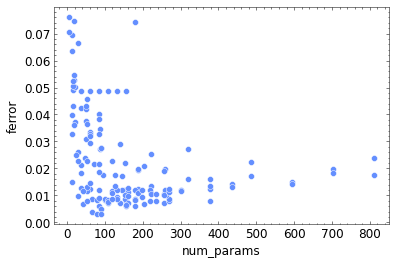

In [55]:
import seaborn as sns

sns.scatterplot(data=data, x='num_params', y='ferror')


<AxesSubplot:xlabel='num_params', ylabel='ferror'>

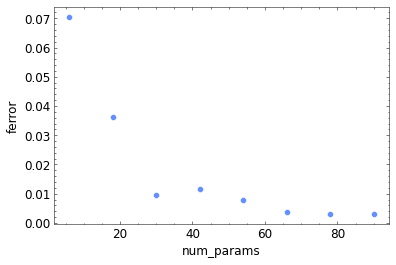

In [56]:
sns.scatterplot(data=data[data['circuit_id']==15], x='num_params', y='ferror')
#plt.xscale('log')

In [57]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
c3 = color_list[3]
c1 = color_list[0]
c2= color_list[4]

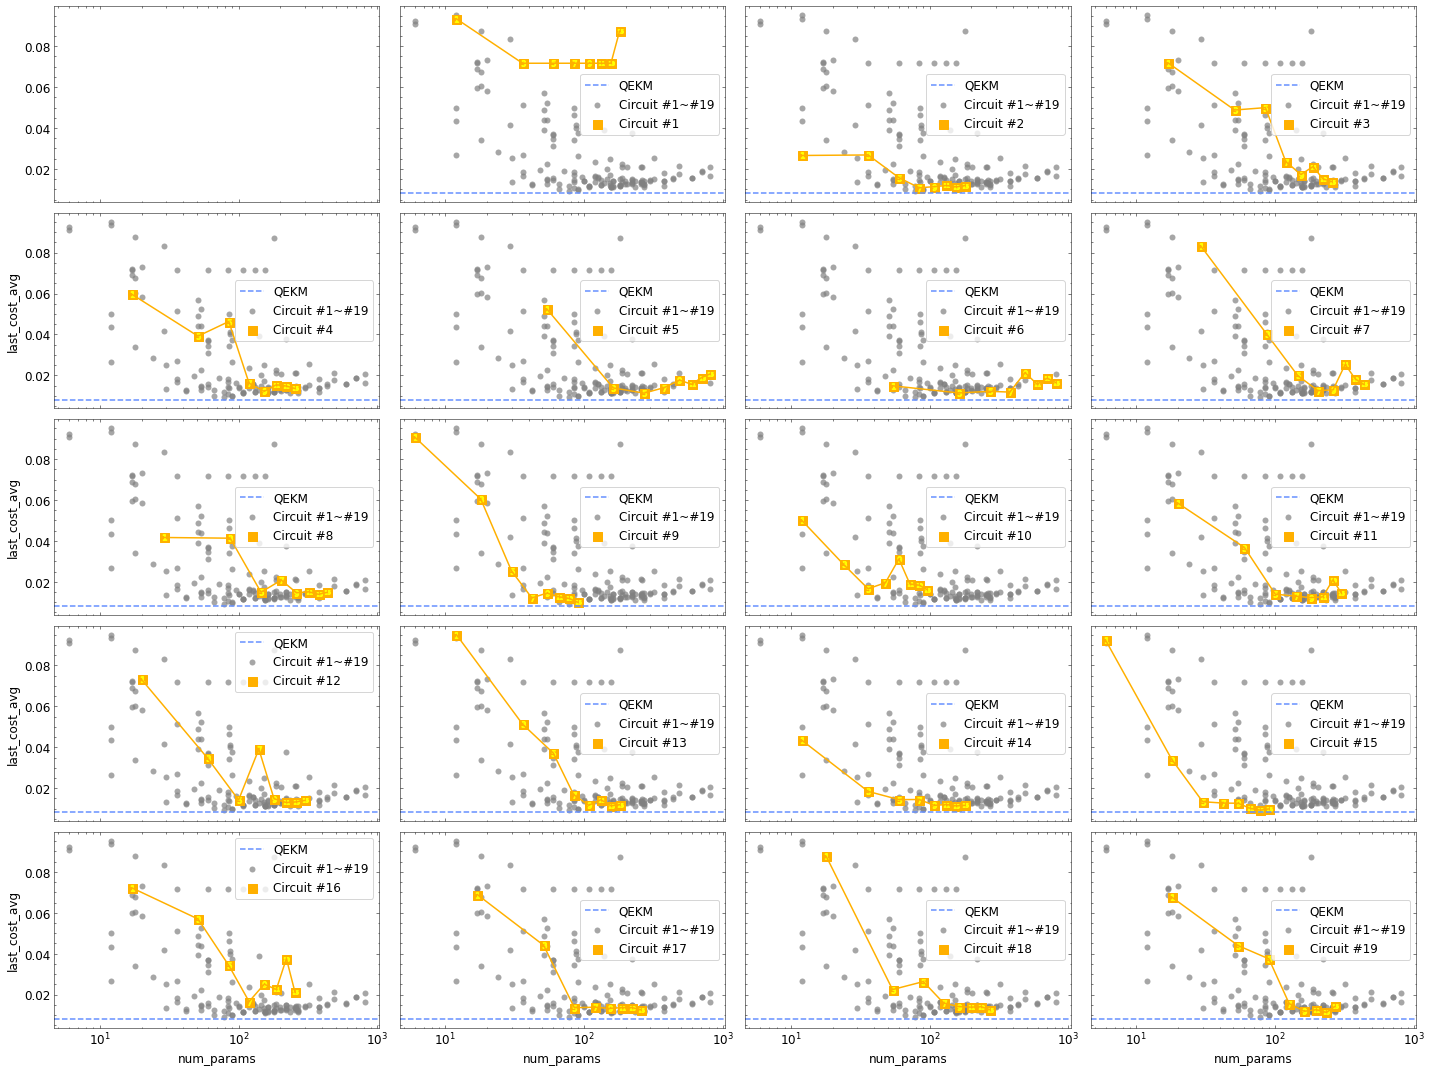

In [58]:
%matplotlib inline
fig, axes = plt.subplots(5, 4, figsize=(20, 15), squeeze=True, sharex=True, sharey=True)
for cid in _setting_qasvm["CIRCUIT_ID"]:
    ax = axes.flatten()[cid%20]
    not15 = data.loc[data['circuit_id']!=cid]
    yes15 = data.loc[data['circuit_id']==cid]
    ax.scatter(not15['num_params'], not15['last_cost_avg'], marker='o', color='grey', alpha=0.7, linewidth=0, label='Circuit #1~#19')#yerr=std_result['num_iter'])
    ax.plot(yes15['num_params'], yes15['last_cost_avg'], marker='', color=c2)
    if cid<20:
        with plt.rc_context({'lines.markersize': 1.5*plt.rcParams['lines.markersize']}):
            ax.scatter(yes15['num_params'], yes15['last_cost_avg'], marker='s', color=c2, label=f'Circuit #{cid}')
    for l in _setting_qasvm["LAYERS"]:
        ax.scatter(yes15.loc[yes15['layer']==l]['num_params'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='yellow')#yerr=std_result['num_iter'])
    ax.axhline(y=svm.dual_objective_value, linestyle='--', label='QEKM', color=c1)
    ax.set_xscale('log')
    if cid%20 in [0, 4, 8, 12, 16]:
        ax.set_ylabel('last_cost_avg')
    if cid%20 in [16, 17, 18, 19]:
        ax.set_xlabel('num_params')
    ax.legend()
plt.tight_layout()
#plt.savefig('./figs/numanal/si_expr_vs_cost.png')
plt.show()

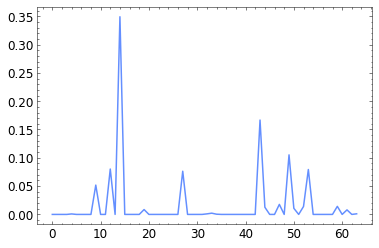

In [59]:
plt.plot(svm.alpha)

In [60]:
data[data['circuit_id']==15]

,dataset,circuit_id,layer,num_params,expr,entcap,num_iter,last_cost_avg,accuracy,ferror
112,0,15,1,6,0.491135,0.682953,1024,0.092334,0.837209,0.070544
113,0,15,3,18,0.112325,0.869515,1024,0.034002,0.883721,0.036227
114,0,15,5,30,0.055550,0.921480,1024,0.013387,0.906977,0.009697
115,0,15,7,42,0.045237,0.937608,1024,0.012726,0.883721,0.011649
116,0,15,9,54,0.037160,0.939952,1024,0.012633,0.918605,0.007857
117,0,15,11,66,0.055875,0.938271,1024,0.010143,0.906977,0.003648
118,0,15,13,78,0.040276,0.938213,1024,0.009265,0.918605,0.002922
119,0,15,15,90,0.041976,0.939841,1024,0.009861,0.895349,0.002991
